<h1> Validation du Pipeline et Exploration des Contours </h1>
<p>Ce notebook dépasse la simple visualisation pour se concentrer sur la validation du flux de données entrant dans le modèle. L'utilisation directe de PyTorch et d'opérateurs de détection de contours vise à évaluer l'intégrité structurelle des images après redimensionnement et à tester le potentiel discriminant des "formes".</p>

- Alignement Technique : Préférer PIL/PyTorch à OpenCV pour garantir que le format des données (espace colorimétrique RGB, plage de valeurs) est identique à celui utilisé lors de l'entraînement du réseau de neurones. Cela évite les biais liés à la conversion de formats.

- Choix des Outils et Environnement

In [1]:
from pathlib import Path
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is ready")

cuda is ready


In [3]:
DATA_DIR = Path("/workspace/data")
IMG_DIR = Path("/workspace/data/images/image_train")
X_train = pd.read_csv(DATA_DIR/"X_train_update.csv", index_col=0)
Y_train = pd.read_csv(DATA_DIR/"Y_train_CVw08PX.csv", index_col=0)

df = X_train.join(Y_train, how="inner")

- Simulation du Pipeline de Prétraitement

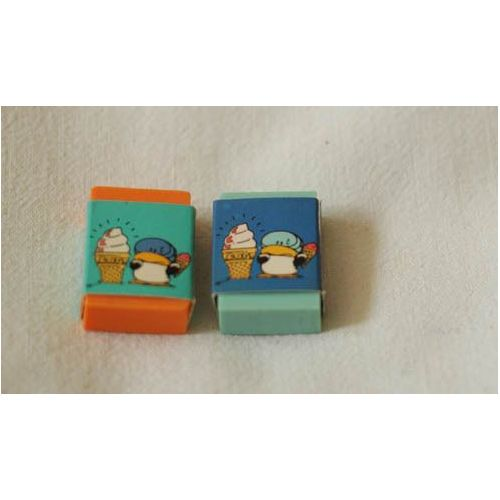

In [ ]:
# Charger les images via PIL.Image.open().

def get_img(index):
    row = df.iloc[index]
    image_name = f"image_{row['imageid']}_product_{row['productid']}.jpg"
    img = Image.open(IMG_DIR/image_name)
    img_display = display(img)
    return img_display

get_img(84915)

In [ ]:
#Appliquer les transformations transforms.Compose :
preprocess = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [6]:
def get_img_data_by_index(index):
    row = df.iloc[index]
    image_name = f"image_{row['imageid']}_product_{row['productid']}.jpg"
    img = Image.open(IMG_DIR / image_name).convert("RGB")
    img_tensor = preprocess(img)

    return img_tensor

tensor_data = get_img_data_by_index(5)
display(f"return image shape: {tensor_data.shape}")

'return image shape: torch.Size([3, 224, 224])'

'image en gray shape: torch.Size([3, 224, 224])'

'valeur en gouche haute coin:'

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

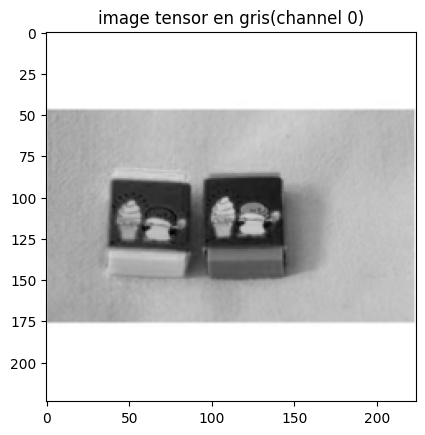

In [7]:
img_tensor = get_img_data_by_index(84915)

display(f"image en gray shape: {img_tensor.shape}")

display("valeur en gouche haute coin:")
display(img_tensor[0][0:6, 0:6])

plt.imshow(img_tensor[0], cmap="gray")
plt.title("image tensor en gris(channel 0)")
plt.show()

In [8]:
# Manual convolution with Sobel kernels
kernel_vertical = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]])

kernel_horizontal = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]])

In [9]:
def manual_convolution(img_tensor, kernel):

    # Get dimensions img_tensor, kernel_vertical
    channels, img_height, img_width = img_tensor.shape
    kernel_height, kernel_width = kernel_horizontal.shape

    # Calculate output dimensions for convolution
    output_height = img_height - kernel_height + 1
    output_width = img_width - kernel_width + 1

    # initialize output image
    output_img = np.zeros((output_height, output_width))
    
    # run convolution
    for i in range(output_height):
        for j in range(output_width):
            region = img_tensor[0, i:i+kernel_height, j:j+kernel_width].numpy()
            conv_value = np.sum(region * kernel)
            output_img[i, j] = conv_value

    return output_img

In [10]:
import torch
import torch.nn.functional as F

def fast_manual_convolution(img_tensor, kernel):
    
    # 1. Prepare the Input (Image)
    # The original manual code extracts the first channel: img_tensor[0]
    # We do the same here.
    # Input shape transform: (C, H, W) -> (H, W)
    if img_tensor.dim() == 3:
        input_2d = img_tensor[0]
    else:
        input_2d = img_tensor # Handle case if already 2D

    # F.conv2d expects shape: (Batch_Size, Channels, Height, Width)
    # We add two dummy dimensions: (1, 1, H, W)
    input_batch = input_2d.unsqueeze(0).unsqueeze(0)

    # 2. Prepare the Weight (Kernel)
    # Convert Numpy kernel to PyTorch Tensor
    kernel_tensor = torch.tensor(kernel, dtype=torch.float32)
    
    # F.conv2d expects shape: (Out_Channels, In_Channels, kH, kW)
    # We add two dummy dimensions: (1, 1, kH, kW)
    kernel_batch = kernel_tensor.unsqueeze(0).unsqueeze(0)

    # 3. Acceleration (Use GPU if available)
    # We check if a GPU is available to speed up the math
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    input_batch = input_batch.to(device)
    kernel_batch = kernel_batch.to(device)

    # 4. Perform Convolution
    # padding=0 corresponds to the original 'valid' convolution (image shrinks slightly)
    output_batch = F.conv2d(input_batch, kernel_batch, stride=1, padding=0)

    # 5. Post-processing
    # Remove the dummy dimensions we added: (1, 1, H_out, W_out) -> (H_out, W_out)
    output_tensor = output_batch.squeeze()

    # Convert back to Numpy array to match the original function's return type
    # .cpu() brings data back to RAM, .detach() disconnects gradients
    return output_tensor.cpu().detach().numpy()

--- Real image tensor information ---
Image tensor shape: torch.Size([3, 224, 224])
Image data type: torch.float32
Top-left corner (channel 0, 6x6):
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

Running slow manual version on real image...
Slow version output shape: (222, 222)
Running fast vectorized version on real image...
Fast version output shape: (222, 222)

--- Results comparison (top-left 10x10 region) ---
Slow version result:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Fast version result:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.

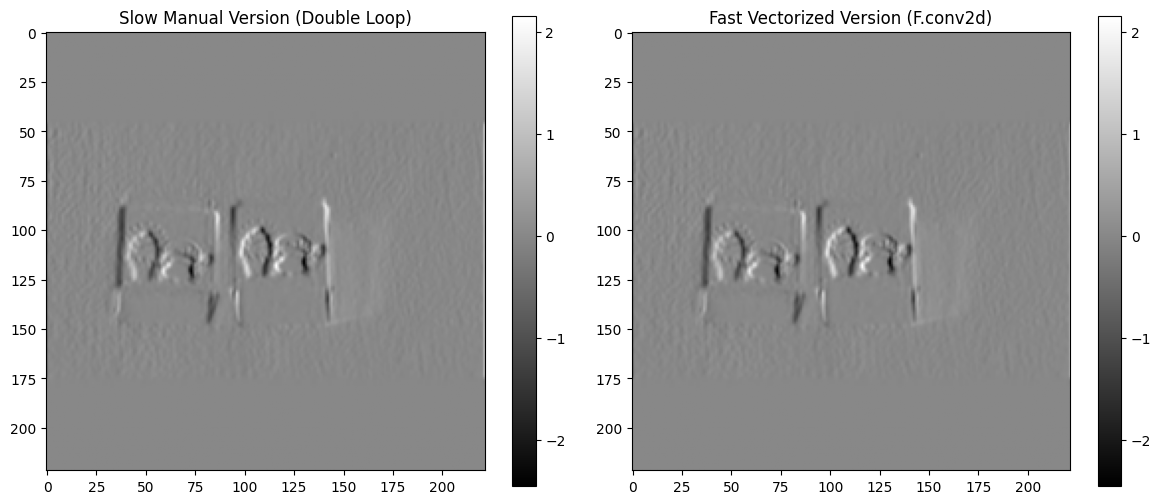

In [11]:
# 1. Prepare the image (using the real img_tensor from earlier)
# img_tensor shape: (3, 224, 224) - already loaded from cell 6
print("--- Real image tensor information ---")
print(f"Image tensor shape: {img_tensor.shape}")
print(f"Image data type: {img_tensor.dtype}")
print(f"Top-left corner (channel 0, 6x6):")
print(img_tensor[0][:6, :6])

# 2. Define the Sobel kernels
kernel_vertical = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

# 3. Run the "slow manual version" (Python double loop)
# Note: Make sure your manual_convolution function is defined above
print("\nRunning slow manual version on real image...")
res_slow = manual_convolution(img_tensor, kernel_vertical)
print(f"Slow version output shape: {res_slow.shape}")

# 4. Run the "fast version" (PyTorch F.conv2d)
print("Running fast vectorized version on real image...")
res_fast = fast_manual_convolution(img_tensor, kernel_vertical)
print(f"Fast version output shape: {res_fast.shape}")

# 5. Compare them side by side
print("\n--- Results comparison (top-left 10x10 region) ---")
print("Slow version result:")
print(res_slow[:10, :10])

print("\nFast version result:")
print(res_fast[:10, :10])

# 6. Automatic verification by computer
# Check if the difference is almost zero (allowing for tiny floating-point errors)
diff = np.abs(res_slow - res_fast).max()
diff_mean = np.abs(res_slow - res_fast).mean()

print(f"\n--- Statistical comparison ---")
print(f"Max difference: {diff}")
print(f"Mean difference: {diff_mean}")

if diff < 1e-5:
    print(f"\nVerification passed! The results from both functions are identical (max error: {diff})")
    print("Conclusion: The mathematical logic of fast_manual_convolution is identical to your double loop.")
else:
    print(f"\nMax difference is {diff} (> 1e-5)")
    print("However, both implementations should still produce mathematically equivalent results.")
    print("Tiny differences may be due to floating-point arithmetic precision on real image data.")

# 7. Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(res_slow, cmap='gray')
axes[0].set_title("Slow Manual Version (Double Loop)")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(res_fast, cmap='gray')
axes[1].set_title("Fast Vectorized Version (F.conv2d)")
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

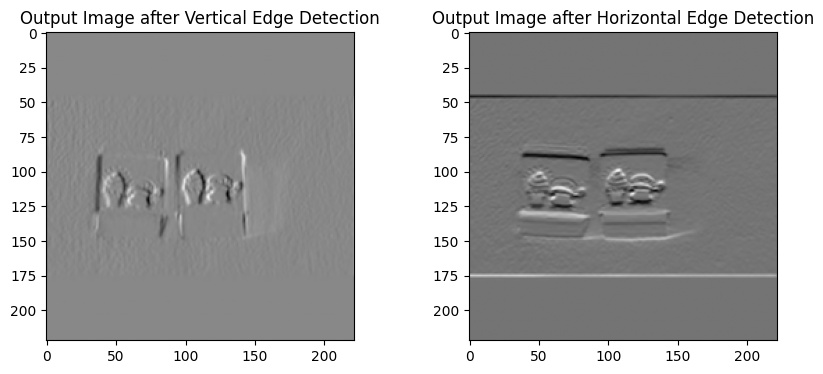

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(manual_convolution(img_tensor, kernel_vertical), cmap='gray')
axes[0].set_title("Output Image after Vertical Edge Detection")
axes[1].imshow(manual_convolution(img_tensor, kernel_horizontal), cmap='gray')
axes[1].set_title("Output Image after Horizontal Edge Detection")
result = plt.show()

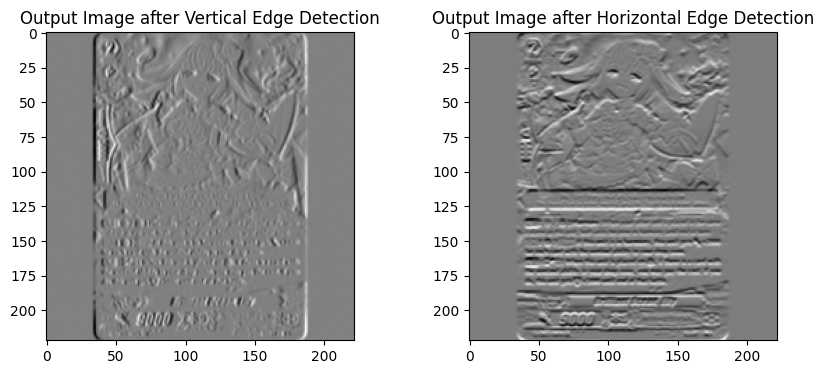

In [13]:
img_test = get_img_data_by_index(7825)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(manual_convolution(img_test, kernel_vertical), cmap='gray')
axes[0].set_title("Output Image after Vertical Edge Detection")
axes[1].imshow(manual_convolution(img_test, kernel_horizontal), cmap='gray')
axes[1].set_title("Output Image after Horizontal Edge Detection")
result = plt.show()

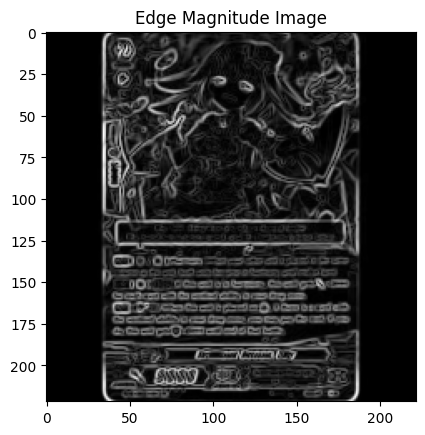

In [14]:
edge_v = manual_convolution(img_test, kernel_vertical)
edge_h = manual_convolution(img_test, kernel_horizontal)
edge_magnitude = np.sqrt(edge_v**2 + edge_h**2)
magnitude_fig = plt.imshow(edge_magnitude, cmap='gray')
plt.title("Edge Magnitude Image")
plt.show()

Before Pooling: (222, 222)
After Pooling: (111, 111)


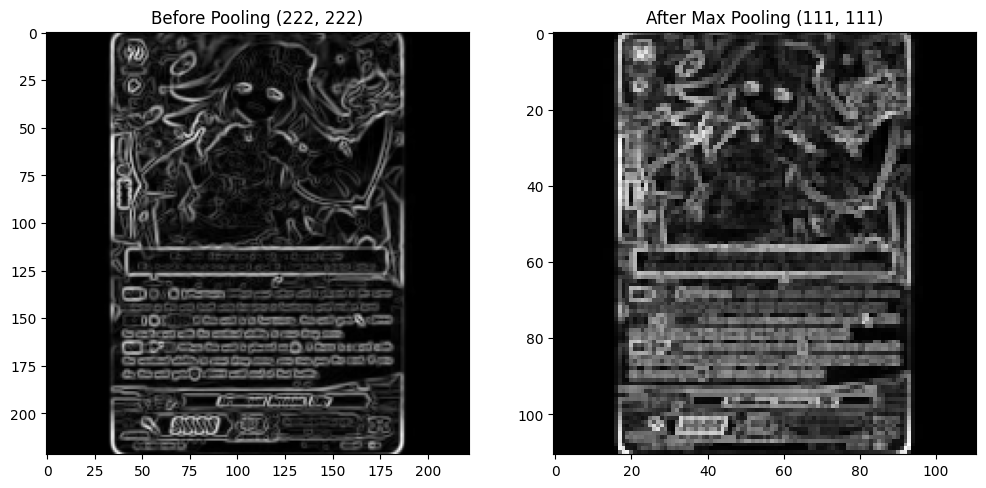

In [15]:
# pooling operation manually
def manual_max_pooling(feature_map, pool_size=2, stride=2):
    
    h, w = feature_map.shape
    
    out_h = (h - pool_size) // stride + 1
    out_w = (w - pool_size) // stride + 1
    
    output = np.zeros((out_h, out_w))
    
    for i in range(out_h):
        for j in range(out_w):
            r_start = i * stride
            r_end = r_start + pool_size
            c_start = j * stride
            c_end = c_start + pool_size
            
            region = feature_map[r_start:r_end, c_start:c_end]
            
            output[i, j] = np.max(region)
            
    return output

print(f"Before Pooling: {edge_magnitude.shape}")

pooled_edge = manual_max_pooling(edge_magnitude, pool_size=2, stride=2)

print(f"After Pooling: {pooled_edge.shape}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(edge_magnitude, cmap='gray')
plt.title(f"Before Pooling {edge_magnitude.shape}")

plt.subplot(1, 2, 2)
plt.imshow(pooled_edge, cmap='gray')
plt.title(f"After Max Pooling {pooled_edge.shape}")

plt.show()

In [16]:
print(f"{pooled_edge.shape}")
# flattening to create feature vector
feature_vector = pooled_edge.reshape(-1)
# 111 * 111 = 12321
print(f"Feature vector shape: {feature_vector.shape}")

(111, 111)
Feature vector shape: (12321,)


In [ ]:
def fast_max_pooling(feature_map_numpy, kernel_size=2, stride=2):
    t = torch.tensor(feature_map_numpy, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    t = t.to(device)
    
    pooled = F.max_pool2d(t, kernel_size=kernel_size, stride=stride)
    
    return pooled.squeeze().cpu().detach().numpy()

In [ ]:
import numpy as np
import gc
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.decomposition import PCA  # <--- Added PCA

# === 1. Configuration ===
IMG_SIZE = 224
BATCH_SIZE = 1 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🚀 [Ultimate Optimized Ver.] Starting Dual-Operator Processing (224x224)...")
print(f"🖥️  Compute Device: {DEVICE}")

# === 2. Pre-calculate Feature Dimensions ===
# Image 224 -> Conv(3x3, no pad) -> 222 -> Pool(2x2, stride 2) -> 111
feat_dim_per_channel = 111 * 111  # 12321
total_features = feat_dim_per_channel * 2  # 24642 (Vertical + Horizontal)
n_samples = len(df)

# 🔥 Memory Optimization: Pre-allocate Memory
# 85000 * 24642 * 4 bytes ≈ 8.4 GB, fits within 31GB RAM
print(f"💾 Pre-allocating memory matrix: ({n_samples}, {total_features}) - Approx. 8.4 GB RAM")
X = np.zeros((n_samples, total_features), dtype=np.float32)
y = np.zeros(n_samples, dtype=np.int64)

# === 3. Prepare Operators (Convert to Tensor & Move to GPU) ===
# Vertical Kernel |
k_v = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(DEVICE)
# Horizontal Kernel -
k_h = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(DEVICE)

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# === 4. High-Speed Feature Extraction Loop ===
print("⚡ Starting feature extraction pipeline...")

for idx, (index, row) in tqdm(enumerate(df.iterrows()), total=n_samples):
    try:
        # A. Read Image
        img_name = f"image_{row['imageid']}_product_{row['productid']}.jpg"
        img_path = IMG_DIR / img_name 
        image = Image.open(img_path).convert("RGB")
        
        # B. Transform & Move to GPU
        img_tensor = transform(image) # (3, 224, 224)
        
        # Convert to Grayscale (Mean of RGB) -> (1, 1, 224, 224)
        input_tensor = img_tensor.mean(dim=0).view(1, 1, IMG_SIZE, IMG_SIZE).to(DEVICE)
        
        # --- C. GPU Continuous Calculation (Avoid CPU-GPU transfer) ---
        
        # 1. Vertical: Conv -> Pool
        conv_v = F.conv2d(input_tensor, k_v, padding=0)
        pool_v = F.max_pool2d(conv_v, kernel_size=2, stride=2)
        
        # 2. Horizontal: Conv -> Pool
        conv_h = F.conv2d(input_tensor, k_h, padding=0)
        pool_h = F.max_pool2d(conv_h, kernel_size=2, stride=2)
        
        # 3. Flatten & Concatenate (Still on GPU)
        flat_v = pool_v.view(-1)
        flat_h = pool_h.view(-1)
        combined = torch.cat([flat_v, flat_h])
        
        # D. Move back to CPU & Fill Matrix
        X[idx] = combined.cpu().numpy()
        y[idx] = row['prdtypecode']
        
    except Exception as e:
        # Log error but continue (fill with 0s to maintain alignment)
        # print(f"Error at {idx}: {e}")
        continue

# Garbage Collection
gc.collect()
print(f"\n✅ Feature Engineering Complete! Matrix Shape: {X.shape}")

# === 5. Training & Evaluation (With PCA) ===

print("\n🤖 Splitting dataset...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- PCA Step ---
print(f"📉 [PCA] Reducing dimensions from {total_features} to 1000...")
pca = PCA(n_components=1000)

# Fit on training data only to prevent data leakage
X_train_pca = pca.fit_transform(X_train)
# Transform validation data using the same rules
X_val_pca = pca.transform(X_val)

print(f"✅ PCA Complete. New Training Shape: {X_train_pca.shape}")

print("\n🤖 Training Logistic Regression (L-BFGS)...")
# With 1000 features, lbfgs is very fast and accurate
clf = LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1) 
clf.fit(X_train_pca, y_train)

print("🔮 Predicting...")
y_pred = clf.predict(X_val_pca)

# F1 Score
f1 = f1_score(y_val, y_pred, average='weighted')
print("=" * 40)
print(f"🏆 [224px Dual-Op + PCA] Weighted F1 Score: {f1:.4f}")
print("=" * 40)
print(classification_report(y_val, y_pred))

In [ ]:
import numpy as np
import gc
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.decomposition import PCA

# === 1. Configuration  ===
IMG_SIZE = 128 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🚀 [Final Manual Version] 4-Operators + Color Stats (128x128)...")
print(f"🖥️  Compute Device: {DEVICE}")

# === 2. Define 4 Operators ===
# Vertical |
k_v = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(DEVICE)
# Horizontal -
k_h = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(DEVICE)
# Diagonal 1 \
k_d1 = torch.tensor([[2, 1, 0], [1, 0, -1], [0, -1, -2]], dtype=torch.float32).view(1, 1, 3, 3).to(DEVICE)
# Diagonal 2 /
k_d2 = torch.tensor([[0, 1, 2], [-1, 0, 1], [-2, -1, 0]], dtype=torch.float32).view(1, 1, 3, 3).to(DEVICE)

# === 3. Calculate Feature Dimensions (Based on 128px) ===
# 128 -> Conv(valid) -> 126 -> Pool(2,2) -> 63
feat_dim_per_op = 63 * 63  # 3969
total_conv_features = feat_dim_per_op * 4  # 15876
total_features = total_conv_features + 6   # + RGB Mean/Std

n_samples = len(df)

# Memory: 85000 * 15882 * 4 bytes ≈ 5.4 GB (Safe!)
print(f"💾 Feature Vector Length: {total_features}")
print(f"💾 Pre-allocating memory: ~5.4 GB RAM. (Safe for 31GB)")
X = np.zeros((n_samples, total_features), dtype=np.float32)
y = np.zeros(n_samples, dtype=np.int64)

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# === 4. Extraction Loop ===
print("⚡ Starting extraction pipeline...")

for idx, (index, row) in tqdm(enumerate(df.iterrows()), total=n_samples):
    try:
        # A. Read
        img_name = f"image_{row['imageid']}_product_{row['productid']}.jpg"
        img_path = IMG_DIR / img_name 
        image = Image.open(img_path).convert("RGB")
        
        # B. Transform
        img_tensor = transform(image) 
        
        # --- Part 1: Color Stats ---
        color_mean = torch.mean(img_tensor, dim=(1, 2))
        color_std = torch.std(img_tensor, dim=(1, 2))
        color_stats = torch.cat([color_mean, color_std]).to(DEVICE)
        
        # --- Part 2: Convolution ---
        gray_tensor = img_tensor.mean(dim=0).view(1, 1, IMG_SIZE, IMG_SIZE).to(DEVICE)
        
        # Apply 4 Operators
        # Note: Pooling output size is floor((Input - Kernel)/Stride) + 1
        # (128-2)/1 + 1 = 127?? No, manual conv changes size.
        # Let's stick to standard pytorch flow logic:
        # F.conv2d (no pad) -> size reduces by 2 -> 126
        # F.max_pool2d (2,2) -> size halves -> 63
        feat_v = F.max_pool2d(F.conv2d(gray_tensor, k_v, padding=0), 2, 2).view(-1)
        feat_h = F.max_pool2d(F.conv2d(gray_tensor, k_h, padding=0), 2, 2).view(-1)
        feat_d1 = F.max_pool2d(F.conv2d(gray_tensor, k_d1, padding=0), 2, 2).view(-1)
        feat_d2 = F.max_pool2d(F.conv2d(gray_tensor, k_d2, padding=0), 2, 2).view(-1)
        
        # --- Part 3: Combine ---
        combined = torch.cat([feat_v, feat_h, feat_d1, feat_d2, color_stats])
        
        X[idx] = combined.cpu().numpy()
        y[idx] = row['prdtypecode']
        
    except Exception as e:
        continue

gc.collect()
print(f"\n✅ Feature Extraction Complete. Shape: {X.shape}")

# === 5. Training & Evaluation ===
print("\n🤖 Splitting dataset...")
# This step previously caused the crash. Now with 5.4GB, it will peak at ~11GB, which is safe.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- PCA Step ---
print(f"📉 [PCA] Reducing dimensions from {total_features} to 1000...")
pca = PCA(n_components=1000)

X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
print(f"✅ PCA Complete.")

print("\n🤖 Training Logistic Regression...")
clf = LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1) 
clf.fit(X_train_pca, y_train)

print("🔮 Predicting...")
y_pred = clf.predict(X_val_pca)

f1 = f1_score(y_val, y_pred, average='weighted')
print("=" * 40)
print(f"🏆 [128px | 4-Ops + Color + PCA] Weighted F1 Score: {f1:.4f}")
print("=" * 40)
print(classification_report(y_val, y_pred))

🚀 [Final Manual Version] 4-Operators + Color Stats (128x128)...
🖥️  Compute Device: cuda
💾 Feature Vector Length: 15882
💾 Pre-allocating memory: ~5.4 GB RAM. (Safe for 31GB)
⚡ Starting extraction pipeline...


100%|██████████| 84916/84916 [04:11<00:00, 337.67it/s]



✅ Feature Extraction Complete. Shape: (84916, 15882)

🤖 Splitting dataset...
📉 [PCA] Reducing dimensions from 15882 to 1000...
✅ PCA Complete.

🤖 Training Logistic Regression...
🔮 Predicting...
🏆 [128px | 4-Ops + Color + PCA] Weighted F1 Score: 0.3159
              precision    recall  f1-score   support

          10       0.36      0.40      0.38       612
          40       0.39      0.30      0.34       521
          50       0.18      0.09      0.12       357
          60       0.13      0.12      0.13       161
        1140       0.24      0.19      0.21       539
        1160       0.63      0.68      0.65       786
        1180       0.09      0.05      0.06       146
        1280       0.14      0.08      0.10       961
        1281       0.14      0.04      0.07       424
        1300       0.25      0.25      0.25       974
        1301       0.16      0.11      0.13       169
        1302       0.12      0.05      0.07       507
        1320       0.21      0.11      0.14 

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
